In [1]:
import gym
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
class FfAgent(object):
    def __init__(self, session, input_size, output_size, gamma=0.99):
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.gamma = gamma
        
        self.observations_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.input_size])
        # expected sum of discounted rewards
        self.esdr_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        self.v_s_ph  = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s)
        self.v_sp_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s')
        self.r_ph    = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # r_t+1
        self.actions_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.output_size])
        #self.reward_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        
        # Shared-parameter policy and value network
        W1 = tf.get_variable("w1", [self.input_size, 128], initializer=tf.initializers.random_normal(stddev=0.01))
        b1 = tf.get_variable("b1", [128], initializer=tf.initializers.random_normal(stddev=0.01))
        W2p = tf.get_variable("w2p", [128, self.output_size], initializer=tf.initializers.random_normal(stddev=0.01)) # policy
        b2p = tf.get_variable("b2p", [self.output_size], initializer=tf.initializers.random_normal(stddev=0.01))
        W2v = tf.get_variable("w2v", [128, 1], initializer=tf.initializers.random_normal(stddev=0.01)) # value
        b2v = tf.get_variable("b2v", [1], initializer=tf.initializers.random_normal(stddev=0.01))
        
        l1 = tf.nn.relu(tf.matmul(self.observations_ph, W1) + b1)
        # this will need to be changed to accommodate the range and character of action values
        l2_logits = tf.matmul(l1, W2p) + b2p
        l2p = tf.nn.softmax(l2_logits)
        l2v = tf.matmul(l1, W2v) + b2v
        
        #self.reinforce_loss = -1.*tf.reduce_sum((self.esdr_ph)*tf.log(l2p))
        self.reinforce_loss = tf.reduce_sum(
            (self.esdr_ph)*tf.nn.softmax_cross_entropy_with_logits(logits=l2_logits, labels=self.actions_ph)
        )
        self.reinforce_optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(self.reinforce_loss)
        
        self.actor_critic_loss = -1.*tf.reduce_sum((self.esdr_ph - self.v_s_ph)*tf.log(l2p)) + tf.reduce_sum(tf.square(l2v - self.esdr_ph))
        self.actor_critic_optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(self.actor_critic_loss)
        
        self.action_predictions = l2p
        self.esdr_predictions = l2v
        
    # For advantage:
    #    Add single timestep reward samples
    #    Add placeholders for estimated V(s) and V(s')
    def trainSarBatches(self, states, actions, discounted_rewards):
        '''
        Expects inputs to be numpy arrays of shape:
            states = [batch_size, num_state_features]
            actions = [batch_size, num_available_actions]
            discounted_rewards = [batch_size, 1]
        
        The idea is that all episodes have been parsed through and shuffled into
        one big batch of training data.
        '''
        
        advantage_feeds = {
            self.observations_ph: states
        }
        #print("shape of discounted rewards:", discounted_rewards.shape)
        
        advantage_fetches = self.esdr_predictions
        
        v_predictions = self.session.run(advantage_fetches, feed_dict=advantage_feeds)
        #print(v_predictions.shape)
        
        optimize_feeds = {
            self.observations_ph: states,
            self.esdr_ph: discounted_rewards,
            self.v_s_ph: v_predictions,
            self.actions_ph: actions
        }
        
        optimize_fetches = [
            self.reinforce_loss,
            #self.actor_critic_loss,
            self.action_predictions,
            self.esdr_predictions,
            self.reinforce_optimizer
            #self.actor_critic_optimizer
        ]
        
        loss, action_predictions, esdr_predictions, _ = self.session.run(optimize_fetches, feed_dict=optimize_feeds)
        return loss, action_predictions, esdr_predictions
    
    def predict(self, state):
        '''
        Expects state to have the shape [num_state_features]
        '''
        
        feeds = {
            self.observations_ph: np.array([state])
        }
        
        fetches = [
            self.action_predictions,
            self.esdr_predictions
        ]
        action_predictions, esdr_predictions = self.session.run(fetches, feed_dict=feeds)
        return action_predictions, esdr_predictions

In [3]:
def prepSarData(states, actions, rewards, gamma=0.99):
    '''
    Converts temporally synced lists of states, actions, and rewards into shuffled
    numpy matrices for training.
    '''
    #print(len(states), len(actions), len(rewards))
    discounted_sum_rewards = 0
    discounted_rewards = []
    for i in range(len(rewards) - 1, -1, -1):
        discounted_sum_rewards = gamma*discounted_sum_rewards + rewards[i]
        discounted_rewards.append(discounted_sum_rewards)
    discounted_rewards = np.expand_dims(np.array(discounted_rewards[::-1]), axis=1)
    
    actions = np.array(actions)
    states = np.array(states)
    indices = [i for i in range(len(actions))]
    np.random.shuffle(indices)
    
    actions_shuffled = actions[indices]
    states_shuffled = states[indices]
    discounted_rewards_shuffled = discounted_rewards[indices]
    
    return actions_shuffled, states_shuffled, discounted_rewards_shuffled

In [4]:
env = gym.make("CartPole-v0")
session = tf.Session()
print(env.observation_space.shape)
print(env.action_space)
num_actions = 0
while env.action_space.contains(num_actions):
    num_actions += 1
agent = FfAgent(session, env.observation_space.shape[0], num_actions)

/home/jg/.local/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
(4,)
Discrete(2)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [5]:
session.run(tf.global_variables_initializer())

In [6]:
def accumulateData(env, agent, max_steps=1000, max_rollouts=50):
    states = []
    actions = []
    rewards = []
    for rollout_count in range(max_rollouts):
        ep_states = []
        ep_actions = []
        ep_rewards = []
        ep_state_t = env.reset()
        ep_states.append(ep_state_t)
        for t in range(max_steps):
            #ep_action_t = np.argmax(agent.predict(ep_state_t)[0][0])
            ep_action_t = np.random.choice(a=[0, 1], p=agent.predict(ep_state_t)[0][0])
            #ep_action_t = env.action_space.sample()
            #print("shape of action:", ep_action_t.shape)
            ep_state_tp1, ep_reward_tp1, done, _ = env.step(ep_action_t)
            #ep_state_tp1, ep_reward_tp1, done, _ = env.step(env.action_space.sample())
            ep_action_t_onehot = np.zeros((2,))
            ep_action_t_onehot[ep_action_t] = 1.
            ep_actions.append(ep_action_t_onehot)
            ep_states.append(ep_state_tp1)
            ep_rewards.append(ep_reward_tp1)
            if done:
                ep_states.pop(-1)
                #ep_rewards.pop(-1)
                break
            ep_state_t = ep_state_tp1
        states.append(ep_states)
        actions.append(ep_actions)
        rewards.append(ep_rewards)
    return states, actions, rewards

In [7]:
average_rewards = []
for i in range(2000):
    states, actions, rewards = accumulateData(env, agent)
    #print(actions[0:10])
    #print(rewards[0:10])
    states_pro = []
    actions_pro = []
    rewards_pro = []
    for j in range(len(actions)):
        ret = prepSarData(actions[j], states[j], rewards[j])
        #states_pro.append(ret[0])
        #actions_pro.append(ret[1])
        #rewards_pro.append(ret[2])
        #print(ret[0].shape, ret[1].shape, ret[2].shape)
        for k in range(1):
            agent.trainSarBatches(ret[0], ret[1], ret[2])
    print(i)
    average_reward = np.average([sum(r) for r in rewards])
    print("average reward: ", average_reward)
    average_rewards.append(average_reward)
    
env.close()

0
average reward:  24.92
1
average reward:  22.3
2
average reward:  28.84
3
average reward:  27.28
4
average reward:  37.58
5
average reward:  53.06
6
average reward:  57.0
7
average reward:  34.04
8
average reward:  44.72
9
average reward:  46.68
10
average reward:  52.44
11
average reward:  61.84
12
average reward:  62.72
13
average reward:  59.82
14
average reward:  72.5
15
average reward:  84.94
16
average reward:  80.8
17
average reward:  97.42
18
average reward:  95.9
19
average reward:  92.18
20
average reward:  100.08
21
average reward:  115.16
22
average reward:  113.92
23
average reward:  114.26
24
average reward:  87.8
25
average reward:  103.16
26
average reward:  113.66
27
average reward:  117.08
28
average reward:  118.06
29
average reward:  111.12
30
average reward:  107.32
31
average reward:  112.86
32
average reward:  132.58
33
average reward:  121.22
34
average reward:  126.44
35
average reward:  133.8
36
average reward:  140.76
37
average reward:  158.74
38
average r

301
average reward:  199.7
302
average reward:  190.44
303
average reward:  195.8
304
average reward:  198.86
305
average reward:  196.28
306
average reward:  199.28
307
average reward:  190.68
308
average reward:  193.98
309
average reward:  198.0
310
average reward:  198.96
311
average reward:  195.72
312
average reward:  199.26
313
average reward:  199.84
314
average reward:  199.86
315
average reward:  200.0
316
average reward:  200.0
317
average reward:  199.86
318
average reward:  199.92
319
average reward:  200.0
320
average reward:  199.7
321
average reward:  200.0
322
average reward:  199.6
323
average reward:  198.72
324
average reward:  193.24
325
average reward:  185.78
326
average reward:  198.12
327
average reward:  198.56
328
average reward:  195.7
329
average reward:  195.68
330
average reward:  196.46
331
average reward:  197.28
332
average reward:  189.52
333
average reward:  193.48
334
average reward:  194.06
335
average reward:  195.04
336
average reward:  195.82
33

600
average reward:  200.0
601
average reward:  200.0
602
average reward:  200.0
603
average reward:  200.0
604
average reward:  200.0
605
average reward:  200.0
606
average reward:  200.0
607
average reward:  200.0
608
average reward:  200.0
609
average reward:  200.0
610
average reward:  199.76
611
average reward:  200.0
612
average reward:  200.0
613
average reward:  200.0
614
average reward:  200.0
615
average reward:  200.0
616
average reward:  200.0
617
average reward:  200.0
618
average reward:  200.0
619
average reward:  200.0
620
average reward:  200.0
621
average reward:  200.0
622
average reward:  200.0
623
average reward:  200.0
624
average reward:  200.0
625
average reward:  200.0
626
average reward:  200.0
627
average reward:  200.0
628
average reward:  200.0
629
average reward:  200.0
630
average reward:  200.0
631
average reward:  200.0
632
average reward:  200.0
633
average reward:  191.66
634
average reward:  194.02
635
average reward:  196.84
636
average reward:  195

897
average reward:  197.96
898
average reward:  191.3
899
average reward:  195.46
900
average reward:  194.38
901
average reward:  192.24
902
average reward:  193.5
903
average reward:  193.22
904
average reward:  189.68
905
average reward:  188.1
906
average reward:  189.82
907
average reward:  187.98
908
average reward:  191.78
909
average reward:  187.38
910
average reward:  194.64
911
average reward:  196.66
912
average reward:  195.16
913
average reward:  191.46
914
average reward:  191.54
915
average reward:  193.12
916
average reward:  197.82
917
average reward:  196.04
918
average reward:  195.96
919
average reward:  195.34
920
average reward:  196.48
921
average reward:  196.5
922
average reward:  196.94
923
average reward:  198.28
924
average reward:  198.5
925
average reward:  194.1
926
average reward:  194.8
927
average reward:  190.04
928
average reward:  195.68
929
average reward:  194.42
930
average reward:  195.02
931
average reward:  198.16
932
average reward:  193.9


1188
average reward:  198.14
1189
average reward:  199.18
1190
average reward:  197.98
1191
average reward:  197.26
1192
average reward:  197.72
1193
average reward:  194.74
1194
average reward:  197.4
1195
average reward:  193.88
1196
average reward:  197.04
1197
average reward:  194.92
1198
average reward:  196.52
1199
average reward:  197.88
1200
average reward:  198.3
1201
average reward:  199.28
1202
average reward:  198.88
1203
average reward:  198.28
1204
average reward:  198.68
1205
average reward:  196.4
1206
average reward:  198.44
1207
average reward:  197.76
1208
average reward:  197.26
1209
average reward:  196.42
1210
average reward:  195.98
1211
average reward:  196.46
1212
average reward:  197.34
1213
average reward:  194.02
1214
average reward:  195.38
1215
average reward:  195.34
1216
average reward:  195.88
1217
average reward:  193.78
1218
average reward:  195.56
1219
average reward:  192.44
1220
average reward:  194.64
1221
average reward:  190.54
1222
average rewa

1473
average reward:  194.46
1474
average reward:  195.2
1475
average reward:  195.58
1476
average reward:  195.72
1477
average reward:  187.7
1478
average reward:  190.48
1479
average reward:  194.06
1480
average reward:  195.78
1481
average reward:  196.28
1482
average reward:  196.96
1483
average reward:  197.36
1484
average reward:  194.42
1485
average reward:  194.16
1486
average reward:  196.0
1487
average reward:  193.82
1488
average reward:  195.64
1489
average reward:  197.4
1490
average reward:  196.84
1491
average reward:  194.38
1492
average reward:  198.22
1493
average reward:  194.14
1494
average reward:  192.08
1495
average reward:  189.88
1496
average reward:  195.54
1497
average reward:  196.74
1498
average reward:  187.12
1499
average reward:  194.08
1500
average reward:  197.0
1501
average reward:  193.04
1502
average reward:  188.62
1503
average reward:  194.12
1504
average reward:  198.32
1505
average reward:  196.7
1506
average reward:  196.98
1507
average reward:

1759
average reward:  198.76
1760
average reward:  196.34
1761
average reward:  196.28
1762
average reward:  193.5
1763
average reward:  190.96
1764
average reward:  195.44
1765
average reward:  185.9
1766
average reward:  194.42
1767
average reward:  188.1
1768
average reward:  183.88
1769
average reward:  190.34
1770
average reward:  187.06
1771
average reward:  188.08
1772
average reward:  190.32
1773
average reward:  191.32
1774
average reward:  189.6
1775
average reward:  188.18
1776
average reward:  187.98
1777
average reward:  188.12
1778
average reward:  189.56
1779
average reward:  188.8
1780
average reward:  189.2
1781
average reward:  187.16
1782
average reward:  185.52
1783
average reward:  186.88
1784
average reward:  183.68
1785
average reward:  186.82
1786
average reward:  173.64
1787
average reward:  178.24
1788
average reward:  185.82
1789
average reward:  189.14
1790
average reward:  184.88
1791
average reward:  188.96
1792
average reward:  187.1
1793
average reward: 

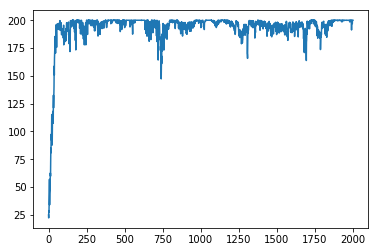

In [8]:
plt.figure()
plt.plot(average_rewards)
plt.show()
env.close()

In [9]:
help(np.random.sample)

Help on built-in function sample in module numpy.random.mtrand:

sample(...)
    This is an alias of `random_sample`. See `random_sample`  for the complete
    documentation.



In [10]:
a = np.random.rand(6)
s = np.random.choice(a=range(6), p=a/sum(a))
print(s)

5


In [11]:
a/sum(a)

array([0.09631988, 0.19829388, 0.07130594, 0.21516431, 0.19090721,
       0.22800877])

In [12]:
help(np.random.choice)

Help on built-in function choice:

choice(...) method of numpy.random.mtrand.RandomState instance
    choice(a, size=None, replace=True, p=None)
    
    Generates a random sample from a given 1-D array
    
            .. versionadded:: 1.7.0
    
    Parameters
    ----------
    a : 1-D array-like or int
        If an ndarray, a random sample is generated from its elements.
        If an int, the random sample is generated as if a were np.arange(a)
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    replace : boolean, optional
        Whether the sample is with or without replacement
    p : 1-D array-like, optional
        The probabilities associated with each entry in a.
        If not given the sample assumes a uniform distribution over all
        entries in a.
    
    Returns
    -------
    samples : si